# Lineær regression - Kan vi estimere antallet af linjer

- **Problem:** Kan jeg med ML estimere antallet af linjer en FED overskrift giver anledning til? Mine input data er FED data, hvor jeg har samlet en overskrift og det tilhørende *antal* linjer strategi hørende til overskriften. Dette er et lineært problem
- **Succes er** Jeg vil undersøge om en *lidt mere avaneret model* kan finde sammenhængen.Her forsøger jeg mig med recurrent
- **Evaluering** Modellen evalueres ved at jeg deler data op i train, validering og test. train og validering opdeles atomatisk af Keras. Modellen valideres på *test*: Jeg plotter faktisk værdi ift predicted værdi. 
- **Data** hentes ud af FED i en tekst-fil. Den videre behandling sker i en Access-database og i et regneark. Input gemmes til sidst i et regneark
- **Baseline** Selv den bedste model har ikke rigtigt gjort det godt ind til nu, der er nok ikke system i data?
- **Optimering vs generalisering** Den får vi se på ...
- **Tuning hyper pametre** Den får vi se på ... 

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. Og den timsvarende omsættelse til inddata til modellen.

![title](FEDentry.GIF)

### Evaluering af forsøg

- første model: den har rigtigt svært ved at genkende små problemer, de overvurderes og bliver estimeret kæmpe store, denne model virker dårligere end en simpel "one-hot" (FED10a)
- Prøver med et "dense layer", og det gør detekteringen af små lidt bedre
- Prøver at indføre lidt dropout, bliver lidt bedre ...
- Prøver mindre dropout, visuelt virker det bedre

### Konklusion
- Det bliver ikke meget bedre end nedenfor
- Jeg har printet de FED-linjer, som modellen mener er store. PErsonligt kan jeg godt se, at mange af dem kunne have været store, så modellen ser vel det samme som jeg, groft taget, ser? At det så ikke helt er i overensstemmelse med hvad der skete i praksis er måske mere et udslag af virkelighedens tilfældighed?

In [1]:
# henter data og lægger pænt i tabeller

# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')

# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 80000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [2]:
# TOKENIZER - laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Fandt %s unikke tokens.' % len(word_index))

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Fandt 21158 unikke tokens.


In [3]:
# Stop sætninger efter dette antal ord
maxlen = 50

# sætninger laves til tekst-vektor og der "paddes"
sequences = tokenizer.texts_to_sequences(texts_train)
data_train = pad_sequences(sequences, maxlen=maxlen)
sequences = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences, maxlen=maxlen)

# labels laves til vektor
NumLines_train = np.asarray(NumLines_train).astype('float32')
NumLines_test = np.asarray(NumLines_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(NumLines_train.shape)
print(NumLines_test.shape)

(80000, 50)
(20867, 50)
(80000,)
(20867,)


In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, LSTM
from keras.layers import Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(LSTM(32,
               dropout=0.1,
               recurrent_dropout=0.1))
model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='rmsprop',    # standard-optimizer
              loss='mse',             # mean square error
              metrics=['mae'])        # mean absolute error

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 8)             80000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 85,793
Trainable params: 85,793
Non-trainable params: 0
_________________________________________________________________


In [5]:
NumEpochs = 10
history = model.fit(data_train, NumLines_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.2)

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 20s 318us/step - loss: 22.2982 - mean_absolute_error: 2.1690 - val_loss: 22.4279 - val_mean_absolute_error: 2.1118
Epoch 2/10
64000/64000 [==============================] - 18s 284us/step - loss: 19.9957 - mean_absolute_error: 1.9956 - val_loss: 20.0233 - val_mean_absolute_error: 2.0118
Epoch 3/10
64000/64000 [==============================] - 18s 284us/step - loss: 18.3314 - mean_absolute_error: 1.9319 - val_loss: 19.2215 - val_mean_absolute_error: 1.9326
Epoch 4/10
64000/64000 [==============================] - 18s 287us/step - loss: 17.6427 - mean_absolute_error: 1.8958 - val_loss: 18.7480 - val_mean_absolute_error: 1.9595
Epoch 5/10
64000/64000 [==============================] - 18s 282us/step - loss: 17.0352 - mean_absolute_error: 1.8840 - val_loss: 18.9040 - val_mean_absolute_error: 1.8485
Epoch 6/10
64000/64000 [==============================] - 18s 282us/step - loss: 16.5

In [6]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [7]:
import matplotlib.pyplot as plt
plt.show()

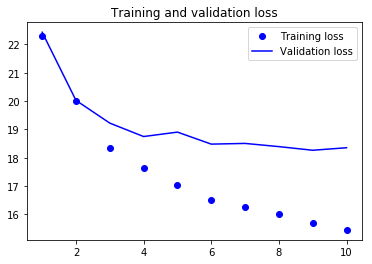

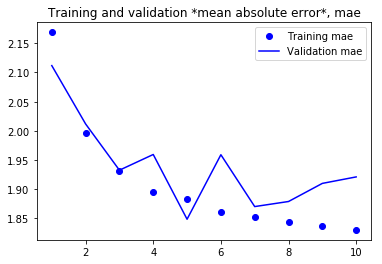

In [8]:
# plotter historikken for 'loss'
loss     = history.history['loss']
val_loss = history.history['val_loss']
mae      = history.history['mean_absolute_error']
val_mae  = history.history['val_mean_absolute_error']

epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # bo = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b  = "solid blue line"
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation *mean absolute error*, mae')
plt.legend()
plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [9]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

2.5754
3.6103
2.6754
2.9709
3.9307
3.0223
1.4192
2.6223
2.6518


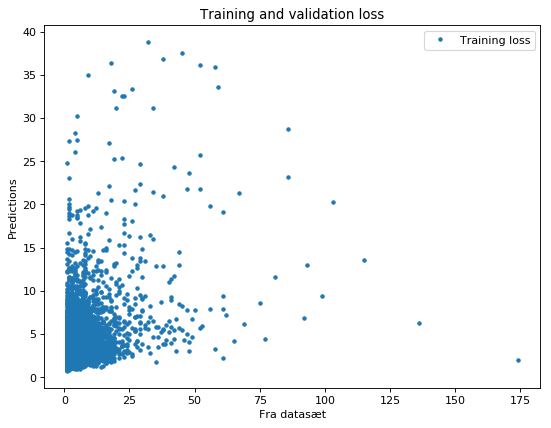

In [10]:
# plotter predictions vs 'hvad den faktisk skal være'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(NumLines_test, predictions, '.', label='Training loss')       # bo = "blue dot"
plt.xlabel('Fra datasæt')
plt.ylabel('Predictions')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
# prøver at forstå de linjer som er små, men som får en stor prediction
print('linje   SkalVære  Prediction  Tekst')
for i in range(1,len(predictions)):
    if NumLines_test[i]<3 and predictions[i]>10:
        PrtStr = (('%5.0f' % i) + '       ' + 
                  ('%4.0f' % NumLines_test[i]) + '        ' + 
                  ('%4.1f' % predictions[i]) + '  ' + 
                  texts_test[i][:70].replace('\n', ' ').replace('\r', ''))
        print(PrtStr)

linje   SkalVære  Prediction  Tekst
  517          2        19.0  Godstog er taget i profilkontrollen ved Øre. Alt trafik holder pt stil
 1304          2        14.9  Manglende korrigering af materieltog, i forbindelse med udtyndning af 
 1620          1        13.7  Signalfejl. Der kan ikke sættes signal i Re sydgående, fejl på bommene
 3003          2        11.6  Signalfejl på Lille Syd mellem Hz og Ol. Samtidigt også løse køer i ve
 3312          2        13.5  Bane danmark: Der er væltet et træ mellem Lundby og Vordingborg. Chefv
 4959          2        10.3  Sporskiftefejl : Lille syd. Fejl på sporskifte ved HD
 5599          2        27.4  Kørestrømmen ustabil mellem Hif-Ro. 36042 holder stille på vej ud af G
 6549          1        15.5  E N K E L S P O R S D R I F T  KY - RG Der er fejlretningspersonale 
 6780          1        13.1  Skal kobles omvendt pga defekt strækningsradio (skrevet til middag, fr
 6895          2        20.1  Spsk i Od mod vest er gået i udu. Der kan ik

In [12]:
# prøver at forstå de linjer som modellen mener er store (predict > 20)
print('linje   SkalVære  Prediction  Tekst')
for i in range(1,len(predictions)):
    if predictions[i]>20:
        PrtStr = (('%5.0f' % i) + '       ' + 
                  ('%4.0f' % NumLines_test[i]) + '        ' + 
                  ('%4.0f' % predictions[i]) + '  ' + 
                  texts_test[i][:70].replace('\n', ' ').replace('\r', ''))
        print(PrtStr)

linje   SkalVære  Prediction  Tekst
  229          5          28  Strategi ifb. med køreledningsnedfald Ky, lagt frem til 12.00. Pt. ing
  292         48          24  Disponering DSB : Grundet den nedfaldende køreledning i VY kobles 8xx 
  548         52          22  Disponering BDK : Måletoget har spærret spor 1 i km 184,7-184,6 pga. s
  634         17          27  Banedanmark     Sporskifte 445 er blevet aflåst, dette gør at vi kun h
  688         19          25  03:00 - Signalfejl: fejlen mellem Sts og Svg bliver ikke klar til morg
  943         13          21  Disponering af opstart når vi kører 41xx/43xx/12xx efter kl.14:00
  974          4          28  Øvrige BDK: fejl på et sporskifte ved kl: det betyder at 44xx aflyses 
 1732         23          20  Personpåkørsel  mellem OK og NI
 2182         38          37  Trolje gået i stå mellem Hz og Th  Skrevet kl.04:34 Fremskrevet 
 2314          9          35  Skrevet 05:10 Sporskiftefejl... Trolje har skåret et sporskifte op, 
 2430 